# Homework 4 (Due Tuesday, April 19th at 6:29pm PST)

## Build A Classification Model w/ Amazon (7pts)

Build a classification model using the **Amazon toy reviews dataset** that is able to predict on a hold-out set the sentiment of the reviews with at minimum 91% accuracy (do not round). 

You may incorporate as many samples as you wish (out of the original ~120,000) data points. However, **the class balance in your training and test set must be 50/50**.

You will likely need to include some preprocessing techniques that we have learned about so far in this course.

If you are unable to achieve 90% accuracy, then please show in this notebook at least **3 different models** that you have tried (ie. RNN using `word2vec`, `GloVe`, logistic regression, etc.)

**Make sure to cite your sources if you use other people's code or ideas.**

In [67]:
## import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string, re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from typing import List, Tuple

In [69]:
# figure size setting
plt.rcParams.update({'figure.figsize':(15,6)})
plt.rcParams.update({'font.size':18})

In [2]:
def load_bbc_corpus(directory: str, topics: List[str], num_docs: int)-> pd.DataFrame:
  # articles: List[Tuple[str, str]] = [(f"datasets/{directory}/{topic}/{str(i).zfill(3)}.txt", topic) for i in range(1,num_docs + 1) for topic in TOPICS]
  articles: List[Tuple[str, str]] = [(f"{directory}/{topic}/{str(i).zfill(3)}.txt", topic) for i in range(1,num_docs + 1) for topic in TOPICS]

  data = []
  for article, topic in articles:
      with open(article, encoding="latin1") as article: # open each sports article
        content = article.read()
        data.append({"topic": topic, "text": content})

  # generate a dataframe
  df = pd.DataFrame(data)
  df.text = df.text.apply(lambda text: text.replace("\n", " "))
  return df

In [7]:
documents = []
TOPICS = ["business", "sport", "entertainment", "tech", "politics"]
news_corpus_df = load_bbc_corpus("bbc", TOPICS, num_docs=386)
news_corpus_df.head()

,topic,text
0,business,Ad sales boost Time Warner profit Quarterly p...
1,sport,Claxton hunting first major medal British hur...
2,entertainment,Gallery unveils interactive tree A Christmas ...
3,tech,Ink helps drive democracy in Asia The Kyrgyz ...
4,politics,Labour plans maternity pay rise Maternity pay...


In [9]:
news_corpus_df['sentiment'] = news_corpus_df.topic.apply(lambda x: 1 if x == 'sport' else 0)
news_corpus_df.head(10)

,topic,text,sentiment
0,business,Ad sales boost Time Warner profit Quarterly p...,0
1,sport,Claxton hunting first major medal British hur...,1
2,entertainment,Gallery unveils interactive tree A Christmas ...,0
3,tech,Ink helps drive democracy in Asia The Kyrgyz ...,0
4,politics,Labour plans maternity pay rise Maternity pay...,0
5,business,Dollar gains on Greenspan speech The dollar h...,0
6,sport,O'Sullivan could run in Worlds Sonia O'Sulliv...,1
7,entertainment,Jarre joins fairytale celebration French musi...,0
8,tech,China net cafe culture crackdown Chinese auth...,0
9,politics,Watchdog probes e-mail deletions The informat...,0


In [16]:
news_corpus_df.text[0]

'Ad sales boost Time Warner profit  Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (Â£600m) for the three months to December, from $639m year-earlier.  The firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.  Time Warner said on Friday that it now owns 8% of search-engine Google. But its own internet business, AOL, had has mixed fortunes. It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. However, the company said AOL\'s underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and will try to sign up 

In [22]:
def clean_text(text):
    """
    Tokenize text into words. Convert texts to lower case.
    Remove hashtags, punctuations, stopwords, website links, extra spaces, non-alphanumeric characters and 
    single character. stemtize texts.
    """

    # # erase html language characters
    # html = re.compile(r'<.*?>')
    # text = html.sub(r'',text)

    # # year phrases
    # text = re.sub(r'(\-?yrs?)', ' year', text)
    # text = re.sub(r'(\-?years?\-?olds?)', ' year old', text)

    # # birthday
    # text = re.sub(r'([Bb]\-?[Dd]ays?)', 'birthday', text)

    # # holiday words
    # text = re.sub(r'([Xx][Mm]as|[Cc]hrist\-[Mm]as)', 'christmas', text)
    # text = re.sub(r'([Nn]ew\-[Yy]ears?)', 'new years', text)

    # numerbers plus units
    text = re.sub(r'\b([1-9]+[\w]*)\b', '_NUMERIC_', text, flags=re.IGNORECASE)
    
    # words with 3 or more of same letters
    text = re.sub(r'\b[a-z0-9]*(.)\1\1+[a-z0-9]*\b', '', text, flags=re.IGNORECASE)

    tokens = [token for token in nltk.word_tokenize(text)]
    
    # Combine stopwords and punctuation
    stops = stopwords.words("english") + list(string.punctuation)

    # # # adding extra stopwords (buy, bought, purchase, purchased)
    stops.append('bbc')
    # stops.append('bought')
    # stops.append('purchase')
    # stops.append('purchased')

    ## the following codes are from my past nlp project that I use when cleaning the text/ tokens

    # special characters
    s_chars = '¥₽ÏïŰŬĎŸæ₿₪ÚŇÀèÅ”ĜåŽÖéříÿý€ŝĤ₹áŜŮÂ₴ûÌÇšŘúüëÓ₫ŠčÎŤÆÒœ₩öËäøÍťìĈôàĥÝ¢ç“žðÙÊĉŭÈŒÐÉÔĵùÁů„âÄűĴóêĝÞîØòď฿ČÜþňÛ'
    
    # Create PorterStemmer
    stemmer = PorterStemmer()
    
    tokens_no_hashtag = [re.sub(r'#', '', token) for token in tokens]
    tokens_no_stopwords = [token.lower() for token in tokens_no_hashtag if token.lower() not in stops]
    tokens_no_url = [re.sub(r'http\S+', '', token) for token in tokens_no_stopwords]
    tokens_no_url = [re.sub(r'www\S+', '', token) for token in tokens_no_url]
    tokens_no_special_char = [re.sub(r'[{}]'.format(s_chars), '', token) for token in tokens_no_url]
    tokens_no_extra_space = [re.sub(r'\s\s+', '', token) for token in tokens_no_special_char]
    tokens_alnum = [token for token in tokens_no_extra_space if token.isalnum()]
    tokens_stem = [stemmer.stem(token) for token in tokens_alnum]
    tokens_final = [token for token in tokens_stem if len(token) > 1]
    
    return ' '.join(tokens_final)

In [23]:
# good_df = pd.DataFrame(good_txt.split('\n'), columns = ['reviews'])
# good_df['review_tok'] = good_df.reviews.apply(clean_text)
# good_df['sentiment'] = 1
# poor_df = pd.DataFrame(poor_txt.split('\n'), columns = ['reviews'])
# poor_df['review_tok'] = poor_df.reviews.apply(clean_text)
# poor_df['sentiment'] = 0
news_corpus_df['review_tok'] = news_corpus_df.text.apply(clean_text)

In [40]:
def to_matrix(doc,n,m):
    # min_df = 10, since we wanted to reduce dimensionality and take away words that were not commonly used
    vectorizer = TfidfVectorizer(ngram_range=(n, m),min_df = 10)
    # when bigram, min_df = 10: column = 15973 
    # when bigram, min_df = 30: column = 3720 
    # when trigram, min_df = 30: column = 427 
    X = vectorizer.fit_transform(doc) 
    X = X.toarray()
    return pd.DataFrame(X, columns=vectorizer.get_feature_names())

In [41]:
mx = to_matrix(news_corpus_df['review_tok'],2,2)
mx

/Users/yamato0615/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,abl get,ac milan,academi award,accord analyst,accord figur,accord mr,accord recent,accord report,accord research,accus mr,...,year mr,year new,year old,year said,year sinc,year time,year would,year year,young peopl,yuko claim
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1925,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1926,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1927,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1928,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
mx_tri = to_matrix(news_corpus_df['review_tok'],3,3)
mx_tri

/Users/yamato0615/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,affair spokesman mark,analyst jupit research,berlin film festiv,best support actor,best support actress,blair mr brown,boss jose mourinho,chancellor gordon brown,chancellor oliv letwin,chief financi offic,...,told news websit,told radio five,told radio today,toni blair said,tori leader michael,two year ago,uk independ parti,us box offic,weapon mass destruct,world cross countri
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1925,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1926,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1927,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1928,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Looking deeper into the n-grams

In [43]:
tf = mx.T
tf['score'] = tf.sum(axis =1)
tf_score = tf[['score']].sort_values(by = 'score',ascending = False).head(30)
tf_score

,score
last year,52.385401
said mr,37.598682
mr blair,29.491084
prime minist,28.503950
new york,27.660348
chief execut,26.422840
last week,24.621513
said would,24.571612
six nation,23.708294
mr brown,23.330227


In [44]:
mx_tri = to_matrix(news_corpus_df['review_tok'],3,3)
print(mx_tri.shape)
tf = mx_tri.T
tf['score'] = tf.sum(axis =1)
tf_score = tf[['score']].sort_values(by = 'score',ascending = False).head(30)
tf_score

(1930, 119)


/Users/yamato0615/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,score
told news websit,50.896251
sir alex ferguson,21.978900
leader michael howard,19.493217
million dollar babi,19.425626
next gener elect,19.220742
mr blair said,18.631883
presid georg bush,18.002677
radio today programm,17.713031
digit music player,17.373684
first time sinc,16.509675


In [48]:
mx_mix = to_matrix(news_corpus_df['review_tok'],2,3)
print(mx_mix.shape)
tf = mx_mix.T
tf['score'] = tf.sum(axis =1)
tf_score = tf[['score']].sort_values(by = 'score',ascending = False).head(30)
tf_score

(1930, 1580)


/Users/yamato0615/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,score
last year,51.540309
said mr,36.827132
mr blair,27.895561
new york,27.263853
prime minist,27.131282
chief execut,25.832149
said would,24.185428
last week,24.083991
six nation,22.892048
mobil phone,22.163100


In [49]:
# split X and y into training and testing sets 

X = mx_mix
y = news_corpus_df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify=y, random_state=1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1351, 1580)
(579, 1580)
(1351,)
(579,)


In [57]:
# import and instantiate a Multinomial Naive Bayes model
nb = MultinomialNB(alpha=0.5)
nb.fit(X_train, y_train)
# make class predictions for X_test_dtm
y_pred = nb.predict(X_test)
# calculate accuracy of class predictions
print(f'The classification rate is {round(metrics.accuracy_score(y_test, y_pred),4)}')

The classification rate is 0.9689


In [61]:
# print the confusion matrix
#Get the confusion matrix
cf_matrix = metrics.confusion_matrix(y_test, y_pred)
print(cf_matrix)

[[455   8]
 [ 10 106]]


In [59]:
# Logistic Regression Model
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
y_c_pred = clf.predict(X_test)
print(f'The classification rate is {round(metrics.accuracy_score(y_test, y_c_pred),4)}')

The classification rate is 0.9257


In [60]:
metrics.confusion_matrix(y_test, y_c_pred)

array([[462,   1],
       [ 42,  74]])

In [62]:
# from https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [63]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

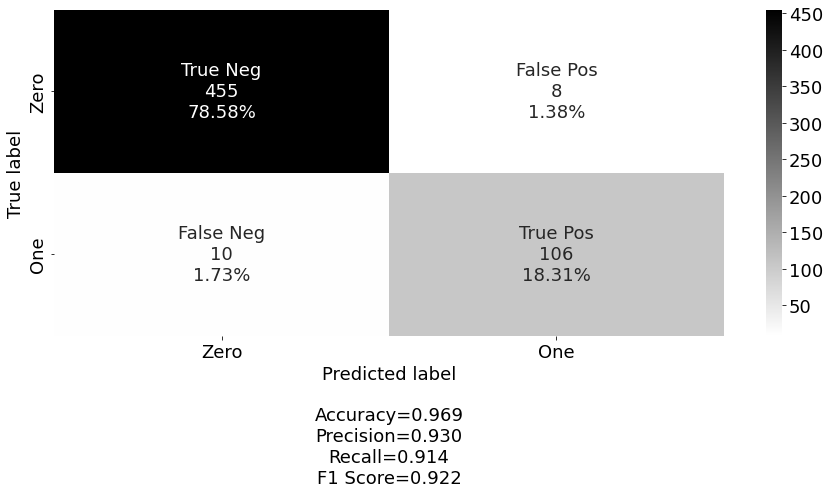

In [70]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='binary')

## Perform Topic Modelling (3 pts)

Perform topic modelling on the `news_categories.csv` dataset. This dataset is from [News Category Dataset, Akash Gupta](https://www.kaggle.com/datasets/akash14/news-category-dataset). You may use the link to find what each `SECTION` integer maps to in terms of a human-readable category.

### Random Seeds

Make sure to set the random seeds in your notebook so I can run your results and get the same exact output:

```python
from numpy.random import seed
seed(42)

from tensorflow import set_random_seed
set_random_seed(32)
```

In [73]:
import pandas as pd
import numpy as np
from numpy.random import seed
seed(42)
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow
tensorflow.random.set_seed(32)

import re, string
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score, accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.decomposition import NMF
from typing import List

# figure size setting
plt.rcParams.update({'figure.figsize':(15,6)})
plt.rcParams.update({'font.size':18})

In [74]:
df = pd.read_csv('news_categories.csv', encoding="latin1")
df.head(3)

,STORY,SECTION
0,But the most painful was the huge reversal in ...,3
1,How formidable is the opposition alliance amon...,0
2,Most Asian currencies were trading lower today...,3


In [75]:
df.shape

(7628, 2)

In [76]:
df.SECTION.value_counts()

1    2772
2    1924
0    1686
3    1246
Name: SECTION, dtype: int64

In [77]:
vectorizer = TfidfVectorizer(ngram_range=(2,3),
                             min_df=0.005, max_df=0.4, stop_words="english")

X, terms = vectorizer.fit_transform(df.STORY), vectorizer.get_feature_names_out()
tf_idf = pd.DataFrame(X.toarray(), columns=terms)
print(f"Sports TF-IDF: {tf_idf.shape}")
tf_idf.head(5)

Sports TF-IDF: (7628, 208)


,000 crore,000mah battery,10 000,10 year,11 april,128gb internal,128gb internal storage,20 pro,4gb ram,4gb ram 64gb,...,voter turnout,west bengal,wi fi,wire agency,wire agency feed,world largest,year ago,year old,year year,years ago
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [82]:
nmf = NMF(n_components=4)
W = nmf.fit_transform(X)
H = nmf.components_
print(f"Original shape of X sports is {X.shape}")
print(f"Decomposed W sports matrix is {W.shape}")
print(f"Decomposed H sports matrix is {H.shape}")

Original shape of X sports is (7628, 208)
Decomposed W sports matrix is (7628, 4)
Decomposed H sports matrix is (4, 208)


/Users/yamato0615/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


In [83]:
def get_top_tf_idf_tokens_for_topic(H: np.array, feature_names: List[str], num_top_tokens: int = 5):
  """
  Uses the H matrix (K components x M original features) to identify for each
  topic the most frequent tokens.
  """
  for topic, vector in enumerate(H):
    print(f"TOPIC {topic}\n")
    total = vector.sum()
    top_scores = vector.argsort()[::-1][:num_top_tokens]
    token_names = list(map(lambda idx: feature_names[idx], top_scores))
    strengths = list(map(lambda idx: vector[idx] / total, top_scores))
    
    for strength, token_name in zip(strengths, token_names):
      print(f"\b{token_name} ({round(strength * 100, 1)}%)\n")
    print(f"=" * 50)

get_top_tf_idf_tokens_for_topic(H, tf_idf.columns.tolist(), 5)

TOPIC 0

lok sabha (8.2%)

prime minister (4.6%)

sabha elections (4.0%)

lok sabha elections (4.0%)

narendra modi (3.9%)

TOPIC 1

modifications text (6.3%)

agency feed (6.3%)

wire agency feed (6.3%)

wire agency (6.3%)

feed modifications text (6.3%)

TOPIC 2

social media (54.8%)

media platforms (6.7%)

year old (6.4%)

san francisco (2.3%)

social network (2.1%)

TOPIC 3

new delhi (48.9%)

mint india (4.5%)

mint india wire (4.5%)

india wire (4.5%)

election commission (2.3%)



In [80]:
def get_top_documents_for_each_topic(W: np.array, documents: List[str], num_docs: int = 5):
  sorted_docs = W.argsort(axis=0)[::-1]
  top_docs = sorted_docs[:num_docs].T
  per_document_totals = W.sum(axis=1)
  for topic, top_documents_for_topic in enumerate(top_docs):
    print(f"Topic {topic}")
    for doc in top_documents_for_topic:
      score = W[doc][topic]
      percent_about_topic = round(score / per_document_totals[doc] * 100, 1)
      print(f"{percent_about_topic}%", documents[doc])
    print("=" * 50)

In [81]:
get_top_documents_for_each_topic(W, df.STORY.tolist())

Topic 0
99.7% We feel we are likely to win at least seven seats in these elections. We are in a strong position in the state


RAIPUR: As Chhattisgarh enters its final phase of polling, former three-time chief minister of the state, Raman Singh, speaks to Mint about the Bharatiya Janata Partys (BJPs) debacle in the assembly elections and its chances in the ongoing polls. Edited excerpts:


What do you think the BJPs chances look like, given the recent drubbing it faced in the assembly polls?


After the Vidhan Sabha elections, the ambience has changed and if you see the 2014 elections, you must know that not only are the patterns different, but the issues also vary greatly. This time the question is who will be the Prime Minister. In places even like Bastar, because of the brand of Prime Minister Narendra Modi, the voter turnout was close to 60%. So we are hoping that the result of the Lok Sabha elections will be good for us.
100.0% Main thoda late ho gaya video banane meinaap mat 